In [2]:
import os
import json
import pandas as pd
from pymongo import MongoClient
from dotenv import load_dotenv

In [3]:
load_dotenv()

mongo_user = os.getenv('MONGO_INITDB_ROOT_USERNAME')
mongo_password = os.getenv('MONGO_INITDB_ROOT_PASSWORD')
mongo_host = 'localhost'
mongo_port = '27017'
mongo_db = 'raw_data'
connection_string = f'mongodb://{mongo_user}:{mongo_password}@{mongo_host}:{mongo_port}/'


In [4]:
collection_name = 'reed_test'

In [91]:
client = MongoClient(connection_string)
db = client[mongo_db]
collection = db[collection_name]

In [92]:
print(client.list_database_names())

['admin', 'config', 'local', 'raw_data']


In [93]:
display(db['reed_test'].find_one())

{'_id': ObjectId('660af8c610971b803a326a21'),
 'employerId': '596284',
 'employerName': 'Hertfordshire County Council',
 'employerProfileId': 'None',
 'employerProfileName': 'None',
 'jobTitle': 'Assistant Customer Service Supervisor',
 'locationName': 'Abbots Langley',
 'minimumSalary': '23500.0',
 'maximumSalary': '25979.0',
 'currency': 'GBP',
 'expirationDate': '13/04/2024',
 'date': '14/03/2024',
 'jobDescription': 'Job Title: Assistant Customer Service Supervisor Location: Abbots Langley Starting Salary: 23,500 with the opportunity to progress to 25,979 per annum (pro rata for part-time) Hours: 18 hours per week Contract: Permanent Diversity: We are an inclusive employer and value a diverse workforce Do you want to make a difference in the community and help people to enrich their lives, whilst progressing in a whole new career? Then apply for a job with H...',
 'applications': '34',
 'jobUrl': 'https://www.reed.co.uk/jobs/assistant-customer-service-supervisor/52311653',
 'source

In [8]:
print("The number of jobs with salary information is", 
    collection.count_documents({
    "$and": [
        {"minimumSalary": {"$ne": 'None'}},
        {"maximumSalary": {"$ne": 'None'}}
    ]
})
)

The number of jobs with salary information is 656466


In [9]:
pipeline = [
    {
        "$match": {
            "$and": [
                {"minimumSalary": {"$eq": 'None'}},
                {"maximumSalary": {"$eq": 'None'}}
            ]
        }
    },
    {
        "$group": {
            "_id": None,  # Grouping all matching documents together
            "count": {"$sum": 1}  # Counting the documents
        }
    }
]

result = list(collection.aggregate(pipeline))

if result:
    print("The number of jobs without salary information is", result[0]['count'])
else:
    print("No jobs found without salary information.")


The number of jobs without salary information is 86762


In [131]:
import re

# Query to select documents where none of the specified fields are empty
query = {
    "$and": [
        {"jobTitle": {"$regex": "data", "$options": "i"}},  # Case-insensitive search for "data" in jobTitle
        {"locationName": {"$ne": ""}},
        {"minimumSalary": {"$ne": ""}},
        {"maximumSalary": {"$ne": ""}},
        {"currency": {"$ne": ""}}
    ]
}

# Projection to specify fields to include, adding 'jobDescription' to the projection
projection = {
    "jobTitle": 1,
    "locationName": 1,
    "minimumSalary": 1,
    "maximumSalary": 1,
    "currency": 1,
    "jobDescription": 1,
    "_id": 0
}

# Fetching the documents with projection
documents = collection.find(query, projection)

def determine_salary_period(description, min_salary, max_salary):
    # Extract the integer part of the min_salary
    min_salary_int = re.match(r'^\d+', str(min_salary))
    if min_salary_int:
        min_salary_int = min_salary_int.group(0)
    else:
        # If no numeric part is found, the function returns "Not specified"
        return "Not specified"
    
    # Define possible salary periods with regex patterns to search for them
    # after the min_salary value
    salary_period_patterns = {
        "per hour": f"{min_salary_int}.*per hour",
        "per day": f"{min_salary_int}.*per day",
        "per week": f"{min_salary_int}.*per week",
        "per month": f"{min_salary_int}.*per month",
        "ph": f"{min_salary_int}.*ph",
        "pd": f"{min_salary_int}.*pd"
    }
    
    # Search for each period pattern in the description
    for period, pattern in salary_period_patterns.items():
        if re.search(pattern, description, re.IGNORECASE):
            return period
    
    # If no period pattern is found, attempt to deduce the period
    # if len(str(min_salary)) >= 6 or len(str(max_salary)) >= 6:
    #     return "per year"
    
    return "Not specified"

data_objects = []
for doc in documents:
    # Determine the salary period
    salary_period = determine_salary_period(doc['jobDescription'], doc['minimumSalary'], doc['maximumSalary'])
    # Add the new field to the document
    doc['salaryPeriod'] = salary_period
    data_objects.append(doc)


In [132]:
# Creating the DataFrame
df_reed = pd.DataFrame(data_objects)

# Showing the first few rows of the DataFrame to verify
display(df_reed.head())

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod
0,Data and Examinations Officer,Kings Langley,22596.0,24589.0,GBP,Job Title: Term Time Data and Examinations Off...,Not specified
1,"Data, Examinations and Admissions Officer",WD49HN,22596.0,24589.0,GBP,"Position: Data, Examinations and Admissions Of...",Not specified
2,Senior Marketing Data Analyst E-Commerce,Watford,65000.0,75000.0,GBP,Senior Marketing Data Analyst (E-Commerce) Up ...,Not specified
3,Senior Marketing Data Analyst E-Commerce,Watford,65000.0,75000.0,GBP,Senior Marketing Data Analyst (E-Commerce) Up ...,Not specified
4,Online Data & Insights Manager,HP79FB,50000.0,55000.0,GBP,"Online Data and Insights Manager - 50,000- 55,...",Not specified


In [133]:
# Creating the dataframe
#df_reed = pd.DataFrame(data_objects)
print(df_reed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8777 entries, 0 to 8776
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   jobTitle        8777 non-null   object
 1   locationName    8777 non-null   object
 2   minimumSalary   8777 non-null   object
 3   maximumSalary   8777 non-null   object
 4   currency        8777 non-null   object
 5   jobDescription  8777 non-null   object
 6   salaryPeriod    8777 non-null   object
dtypes: object(7)
memory usage: 480.1+ KB
None


In [134]:
df_reed['minimumSalary'] = pd.to_numeric(df_reed['minimumSalary'], errors='coerce')
df_reed['maximumSalary'] = pd.to_numeric(df_reed['maximumSalary'], errors='coerce')

df_reed.head(10)

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod
0,Data and Examinations Officer,Kings Langley,22596.0,24589.0,GBP,Job Title: Term Time Data and Examinations Off...,Not specified
1,"Data, Examinations and Admissions Officer",WD49HN,22596.0,24589.0,GBP,"Position: Data, Examinations and Admissions Of...",Not specified
2,Senior Marketing Data Analyst E-Commerce,Watford,65000.0,75000.0,GBP,Senior Marketing Data Analyst (E-Commerce) Up ...,Not specified
3,Senior Marketing Data Analyst E-Commerce,Watford,65000.0,75000.0,GBP,Senior Marketing Data Analyst (E-Commerce) Up ...,Not specified
4,Online Data & Insights Manager,HP79FB,50000.0,55000.0,GBP,"Online Data and Insights Manager - 50,000- 55,...",Not specified
5,Data Migration Temp,Borehamwood,14.0,15.0,GBP,Temporary Data focused temp required for a bus...,Not specified
6,CRM & Customer Data Manager,HP11AE,50000.0,55000.0,GBP,Proximity Recruitment are searching for a dyna...,Not specified
7,Data Entry Clerk,Watford,NaN,NaN,None,Job Opportunity: Data Entry Clerk (Temporary) ...,Not specified
8,Online Data and Insight Manager,Amersham,40000.0,50000.0,GBP,Online Data and Insight Manager Amersham Perma...,Not specified
9,Senior Marketing Data Analyst E-Commerce,Watford,65000.0,75000.0,GBP,Senior Marketing Data Analyst (E-Commerce) Up ...,Not specified


In [135]:
df_reed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8777 entries, 0 to 8776
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   jobTitle        8777 non-null   object 
 1   locationName    8777 non-null   object 
 2   minimumSalary   7787 non-null   float64
 3   maximumSalary   7787 non-null   float64
 4   currency        8777 non-null   object 
 5   jobDescription  8777 non-null   object 
 6   salaryPeriod    8777 non-null   object 
dtypes: float64(2), object(5)
memory usage: 480.1+ KB


In [136]:
df_reed.dropna(inplace=True)

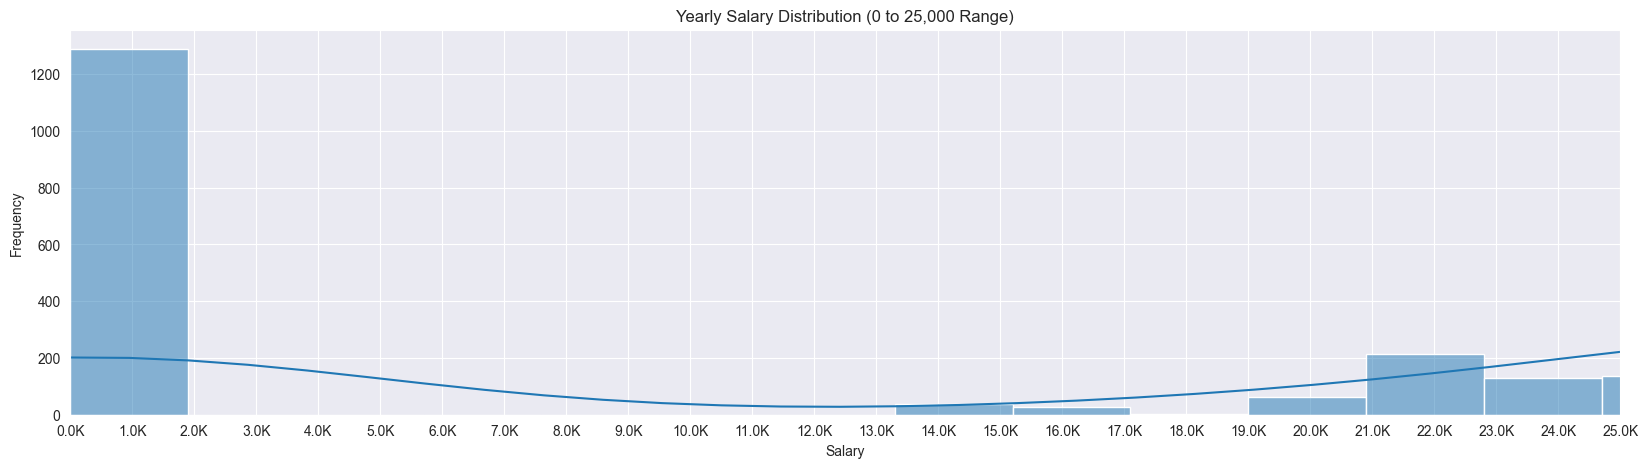

In [137]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.figure(figsize=(20, 5))
# Adjust the bin size and limit the x-axis to focus on 0 to 25,000 range
sns.histplot(df_reed['minimumSalary'], bins=100, kde=True)
plt.xlim(0, 25000)  # Focus on the 0 to 25,000 range

# Customize x-axis tick labels for better clarity
plt.xticks(range(0, 25001, 1000), labels=[f'{x/1000}K' for x in range(0, 25001, 1000)])

plt.title('Yearly Salary Distribution (0 to 25,000 Range)')
plt.xlabel('Salary')
plt.ylabel('Frequency')
plt.show()

In [138]:
df_reed.sort_values(by='minimumSalary', inplace=True)
test_list = df_reed['minimumSalary']

unique_list = list(dict.fromkeys(test_list))
print(unique_list)


[0.0, 10.0, 10.39, 10.42, 10.5, 10.92, 10.93, 10.95, 11.17, 11.3, 11.44, 11.5, 12.0, 12.11, 12.25, 12.5, 12.55, 12.72, 12.82, 12.87, 12.92, 13.0, 13.03, 14.0, 14.46, 14.66, 15.0, 15.38, 15.52, 17.0, 17.86, 18.01, 20.0, 21.0, 22.01, 22.51, 24.0, 35.09, 39.71, 41.35, 52.0, 60.0, 65.0, 92.52, 100.0, 110.0, 160.0, 170.0, 200.0, 250.0, 300.0, 325.0, 350.0, 400.0, 450.0, 480.0, 495.0, 500.0, 550.0, 600.0, 650.0, 700.0, 900.0, 13500.0, 14000.0, 14144.0, 15000.0, 16000.0, 18000.0, 20000.0, 21000.0, 21450.0, 22000.0, 22500.0, 22596.0, 22681.0, 23000.0, 23350.0, 23400.0, 23868.0, 24000.0, 24294.0, 24500.0, 24800.0, 25000.0, 25681.0, 26000.0, 27000.0, 27500.0, 27789.0, 28000.0, 28500.0, 29000.0, 29777.0, 30000.0, 30151.0, 30225.0, 30473.0, 30984.0, 32000.0, 32287.0, 32500.0, 33000.0, 33024.0, 33500.0, 33850.0, 33945.0, 34000.0, 34326.0, 34393.0, 35000.0, 35392.0, 36090.0, 37000.0, 37099.0, 37242.0, 38000.0, 38746.0, 39267.0, 40000.0, 40038.0, 40439.0, 40701.0, 41000.0, 41206.0, 41383.0, 41659.0, 

In [139]:
df_reed = df_reed[df_reed['minimumSalary'] > 0]

In [140]:
df_reed['salaryPeriod'].value_counts()

salaryPeriod
Not specified    7440
per day           156
per hour          101
ph                 41
pd                 26
per week            6
Name: count, dtype: int64

In [142]:
def transform_salary_to_yearly(df, salary_col, period_col):
    """
    Adjusts salary values in the DataFrame to yearly equivalents based on the salary period.
    
    Parameters:
    - df: Pandas DataFrame containing the salary data.
    - salary_col: The name of the column containing the salary values.
    - period_col: The name of the column containing the salary period descriptions.
    """
    
    # Ensure the columns exist in the DataFrame
    if salary_col not in df.columns:
        raise ValueError(f"Column '{salary_col}' not found in DataFrame")
    if period_col not in df.columns:
        raise ValueError(f"Column '{period_col}' not found in DataFrame")
    
    # Conversion rates based on the salary period
    conversion_rates = {
        "per year": 1,
        "per month": 12,
        "per week": 52,
        "per day": 260,  # Assuming 5 working days per week
        "pd" : 260,
        "per hour": 2080,  # Assuming 40 hours per week
        "ph": 2080,
        "Not specified": 1  # No change for unspecified
    }
    
    # Define a function to convert salary to yearly
    def salary_to_yearly(row):
        period = row[period_col]
        salary = row[salary_col]
        # Handle non-numeric salaries by returning them unmodified
        try:
            numeric_salary = float(salary)
        except ValueError:
            return salary  # Return the original salary if it's not a numeric value
        
        # Apply conversion based on the salary period
        if period in conversion_rates:
            return numeric_salary * conversion_rates[period]
        else:
            return numeric_salary  # Return the original salary if the period is unexpected

    # Apply the conversion function to rows
    df[salary_col + '_yearly'] = df.apply(salary_to_yearly, axis=1)
    
    return df


In [143]:
for column in ['minimumSalary', 'maximumSalary']:
    df_reed_salary_tr = transform_salary_to_yearly(df_reed, column, 'salaryPeriod')
    
df_reed_salary_tr.head(2000)

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod,minimumSalary_yearly,maximumSalary_yearly
8066,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,Not specified,10.0,10.0
8027,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8051,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
2885,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8057,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,Not specified,10.0,10.0
...,...,...,...,...,...,...,...,...,...
4965,Data Centre Technician,Farnborough,28000.0,32000.0,GBP,Data Centre Technician 28000 - 32000 Farnborou...,Not specified,28000.0,32000.0
6830,Systems & Data Analyst,M202AF,28000.0,28000.0,GBP,Innova Search are partnering with a leading br...,Not specified,28000.0,28000.0
6218,"Data Analyst, Python, Pandas, Fully Remote, CO...",M607RA,28000.0,34000.0,GBP,"Data Analyst, Python, Pandas, Fully Remote, CO...",Not specified,28000.0,34000.0
6837,"Data Analyst, Python, Pandas, Fully Remote, CO...",M607RA,28000.0,34000.0,GBP,"Data Analyst, Python, Pandas, Fully Remote, CO...",Not specified,28000.0,34000.0


In [148]:
df_reed_salary_tr.loc[df_reed_salary_tr['minimumSalary'] < 70, 'salaryPeriod'] = 'per hour'
df_reed_salary_tr.loc[(df_reed_salary_tr['minimumSalary'] >= 70) & (df_reed_salary_tr['minimumSalary'] < 999), 'salaryPeriod'] = 'per day'
df_reed_salary_tr.head(200)

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod,minimumSalary_yearly,maximumSalary_yearly
8066,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,per hour,20800.0,20800.0
8027,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8051,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
2885,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8057,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,per hour,20800.0,20800.0
...,...,...,...,...,...,...,...,...,...
2498,Data Processor,Clapham,14.0,14.0,GBP,Data Processor Clapham 14 per hour Full-Time T...,per hour,29120.0,29120.0
1604,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0
4011,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0
3172,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0


In [149]:
for column in ['minimumSalary', 'maximumSalary']:
    df_reed_salary_tr = transform_salary_to_yearly(df_reed, column, 'salaryPeriod')
df_reed_salary_tr.head(200)

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod,minimumSalary_yearly,maximumSalary_yearly
8066,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,per hour,20800.0,20800.0
8027,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8051,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
2885,Data Entry Administrator - Remote,Milton Keynes,10.0,11.0,GBP,Title: Data Entry Administrator Location: Milt...,per hour,20800.0,22880.0
8057,Data Entry,NR104JJ,10.0,10.0,GBP,Are you looking for work starting from 10th Oc...,per hour,20800.0,20800.0
...,...,...,...,...,...,...,...,...,...
2498,Data Processor,Clapham,14.0,14.0,GBP,Data Processor Clapham 14 per hour Full-Time T...,per hour,29120.0,29120.0
1604,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0
4011,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0
3172,Data Protection Coordinator,London,14.0,15.0,GBP,Office Angels are looking for a dynamic and pr...,per hour,29120.0,31200.0


In [153]:
display(df_reed_salary_tr.loc[df_reed_salary_tr['salaryPeriod'] == 'Not specified'])

,jobTitle,locationName,minimumSalary,maximumSalary,currency,jobDescription,salaryPeriod,minimumSalary_yearly,maximumSalary_yearly
8523,Data/Admin Apprentice,PO168TT,13500.0,13500.0,GBP,About us:&nbsp; P Fitzsimmons Ltd is part of D...,Not specified,13500.0,13500.0
4735,Data/Admin Apprentice,PO168TT,13500.0,13500.0,GBP,About us:&nbsp; P Fitzsimmons Ltd is part of D...,Not specified,13500.0,13500.0
8578,Data/Admin Apprentice,PO168TT,13500.0,13500.0,GBP,About us:&nbsp; P Fitzsimmons Ltd is part of D...,Not specified,13500.0,13500.0
8541,Data/Admin Apprentice,PO168TT,13500.0,13500.0,GBP,About us:&nbsp; P Fitzsimmons Ltd is part of D...,Not specified,13500.0,13500.0
958,Head of Group Data Management,London,14000.0,14000.0,GBP,Eames is currently partnered with a global (re...,Not specified,14000.0,14000.0
...,...,...,...,...,...,...,...,...,...
7862,Head of Data Operations,SE19PH,190000.0,230000.0,GBP,Head of Data Operations. Global Financial Serv...,Not specified,190000.0,230000.0
7993,Head of Data Operations,SE19PH,190000.0,230000.0,GBP,Head of Data Operations. Global Financial Serv...,Not specified,190000.0,230000.0
6415,Head of Data Operations,SE19PH,190000.0,230000.0,GBP,Head of Data Operations. Global Financial Serv...,Not specified,190000.0,230000.0
1242,Head of Data Operations,SE19PH,190000.0,230000.0,GBP,Head of Data Operations. Global Financial Serv...,Not specified,190000.0,230000.0


In [ ]:
"""
import spacy

# Load the pre-trained model
nlp = spacy.load('en_core_web_sm')  # Or 'en_core_web_lg' for more accuracy but larger size      


# Categorize job titles
def categorize_title(job_title):
    doc = nlp(job_title)
    # List of keywords (lemmas) to look for
    keywords = ['strategic', 'principal', 'staff', 'lead', 'senior', 'head']
    # Check if any token's lemma is in our keywords list
    if any(token.lemma_.lower() in keywords for token in doc):
        return 'Senior'
    else:
        return 'Any'


# Apply the function to create a new column
df_reed['jobLevel'] = df_reed['jobTitle'].apply(categorize_title)
"""

In [ ]:
df_reed.head()